In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import pprint
import pyspark
import pyspark.sql.functions as F

from pyspark.sql.functions import col, regexp_replace, ceil, split, size, when
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorSlicer
from pyspark.ml import Pipeline

import utils.data_processing_bronze_table
import utils.data_processing_silver_table
import utils.data_processing_gold_table


## Set Up PySpark Session

In [2]:
# Initialize SparkSession
spark = pyspark.sql.SparkSession.builder \
    .appName("dev") \
    .master("local[*]") \
    .getOrCreate()

# Set log level to ERROR to hide warnings
spark.sparkContext.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 11:08:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Set Up Config

In [3]:
# set up config
snapshot_date_str = "2023-01-01"

start_date_str = "2023-01-01"
end_date_str = "2025-12-01"

In [4]:
# generate list of dates to process
def generate_first_of_month_dates(start_date_str, end_date_str):
    # Convert the date strings to datetime objects
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d")
    
    # List to store the first of month dates
    first_of_month_dates = []

    # Start from the first of the month of the start_date
    current_date = datetime(start_date.year, start_date.month, 1)

    while current_date <= end_date:
        # Append the date in yyyy-mm-dd format
        first_of_month_dates.append(current_date.strftime("%Y-%m-%d"))
        
        # Move to the first of the next month
        if current_date.month == 12:
            current_date = datetime(current_date.year + 1, 1, 1)
        else:
            current_date = datetime(current_date.year, current_date.month + 1, 1)

    return first_of_month_dates

dates_str_lst = generate_first_of_month_dates(start_date_str, end_date_str)
dates_str_lst

['2023-01-01',
 '2023-02-01',
 '2023-03-01',
 '2023-04-01',
 '2023-05-01',
 '2023-06-01',
 '2023-07-01',
 '2023-08-01',
 '2023-09-01',
 '2023-10-01',
 '2023-11-01',
 '2023-12-01',
 '2024-01-01',
 '2024-02-01',
 '2024-03-01',
 '2024-04-01',
 '2024-05-01',
 '2024-06-01',
 '2024-07-01',
 '2024-08-01',
 '2024-09-01',
 '2024-10-01',
 '2024-11-01',
 '2024-12-01',
 '2025-01-01',
 '2025-02-01',
 '2025-03-01',
 '2025-04-01',
 '2025-05-01',
 '2025-06-01',
 '2025-07-01',
 '2025-08-01',
 '2025-09-01',
 '2025-10-01',
 '2025-11-01',
 '2025-12-01']

In [5]:
# helper function to inspect output
def inspect_output(directory):
    files = sorted(os.listdir(directory))
    latest_file = [f for f in files if not f.startswith("_")][-1]
    path = os.path.join(directory, latest_file)

    if path.endswith(".parquet"):
        df = spark.read.parquet(path)
    elif path.endswith(".csv"):
        df = spark.read.csv(path, header=True, inferSchema=True)
    else:
        raise ValueError("Unsupported file format")

    return df.toPandas().head()

## Build Bronze Tables

### lms_loan_daily.csv

Partitioned monthly based on snapshot dates because temporal

In [6]:
# create bronze datalake for loan dataset
bronze_loan_directory = "datamart/bronze/lms_loan_daily/"
loan_csv_file_path = "data/lms_loan_daily.csv"

if not os.path.exists(bronze_loan_directory):
    os.makedirs(bronze_loan_directory)

In [7]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table_partition(date_str, loan_csv_file_path, bronze_loan_directory, spark)

2023-01-01 row count: 530
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_01_01.csv
2023-02-01 row count: 1031
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_02_01.csv
2023-03-01 row count: 1537
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_03_01.csv
2023-04-01 row count: 2047
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_04_01.csv
2023-05-01 row count: 2568
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_05_01.csv
2023-06-01 row count: 3085
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_06_01.csv
2023-07-01 row count: 3556
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_07_01.csv
2023-08-01 row count: 4037
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_08_01.csv
2023-09-01 row count: 4491
Saved to: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_09_01.csv
2023-10-01 row count: 4978
Saved to: datamart/bronze/lms

In [8]:
# inspect output
inspect_output(bronze_loan_directory)

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date
0,CUS_0x1009_2025_01_01,CUS_0x1009,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
1,CUS_0x1098_2025_01_01,CUS_0x1098,2025-01-01,10,10,10000,1000.0,0.0,8000.0,8000.0,2025-11-01
2,CUS_0x109f_2025_01_01,CUS_0x109f,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
3,CUS_0x10b6_2025_01_01,CUS_0x10b6,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01
4,CUS_0x10e2_2025_01_01,CUS_0x10e2,2025-01-01,10,10,10000,1000.0,1000.0,0.0,0.0,2025-11-01


### feature_clickstream.csv

Partitioned monthly based on snapshot dates because temporal

In [9]:
# create bronze datalake for clickstream csv
bronze_clickstream_directory = "datamart/bronze/feature_clickstream/"
clickstream_csv_file_path = "data/feature_clickstream.csv"

if not os.path.exists(bronze_clickstream_directory):
    os.makedirs(bronze_clickstream_directory)

In [10]:
# run bronze backfill
for date_str in dates_str_lst:
    utils.data_processing_bronze_table.process_bronze_table_partition(date_str, clickstream_csv_file_path, bronze_clickstream_directory, spark)

2023-01-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_01_01.csv
2023-02-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_02_01.csv
2023-03-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_03_01.csv
2023-04-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_04_01.csv
2023-05-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_05_01.csv
2023-06-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_06_01.csv
2023-07-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_07_01.csv
2023-08-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_08_01.csv
2023-09-01 row count: 8974
Saved to: datamart/bronze/feature_clickstream/bronze_

Saved to: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2024_12_01.csv
2025-01-01 row count: 0
No data for snapshot_date: 2025-01-01
2025-02-01 row count: 0
No data for snapshot_date: 2025-02-01
2025-03-01 row count: 0
No data for snapshot_date: 2025-03-01
2025-04-01 row count: 0
No data for snapshot_date: 2025-04-01
2025-05-01 row count: 0
No data for snapshot_date: 2025-05-01
2025-06-01 row count: 0
No data for snapshot_date: 2025-06-01
2025-07-01 row count: 0
No data for snapshot_date: 2025-07-01
2025-08-01 row count: 0
No data for snapshot_date: 2025-08-01
2025-09-01 row count: 0
No data for snapshot_date: 2025-09-01
2025-10-01 row count: 0
No data for snapshot_date: 2025-10-01
2025-11-01 row count: 0
No data for snapshot_date: 2025-11-01
2025-12-01 row count: 0
No data for snapshot_date: 2025-12-01


In [11]:
# inspect output
inspect_output(bronze_clickstream_directory)

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01


### features_attributes.csv

Not partitioned monthly based on snapshot dates because customer particulars

In [12]:
# create bronze datalake for attributes csv
bronze_attributes_directory = "datamart/bronze/features_attributes/"
attributes_csv_file_path = "data/features_attributes.csv"

if not os.path.exists(bronze_attributes_directory):
    os.makedirs(bronze_attributes_directory)

In [13]:
# run bronze backfill
utils.data_processing_bronze_table.process_bronze_table_simple(attributes_csv_file_path, bronze_attributes_directory, spark)

Total row count: 12500
Saved to: datamart/bronze/features_attributes/bronze_features_attributes.csv


DataFrame[Customer_ID: string, Name: string, Age: string, SSN: string, Occupation: string, snapshot_date: date]

In [14]:
# inspect output
inspect_output(bronze_attributes_directory)

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date
0,CUS_0x1000,Alistair Barrf,18,913-74-1218,Lawyer,2023-05-01
1,CUS_0x1009,Arunah,26,063-67-6938,Mechanic,2025-01-01
2,CUS_0x100b,Shirboni,19,#F%$D@*&8,Media_Manager,2024-03-01
3,CUS_0x1011,Schneyerh,44,793-05-8223,Doctor,2023-11-01
4,CUS_0x1013,Cameront,44,930-49-9615,Mechanic,2023-12-01


### features_financials.csv

Not partitioned monthly based on snapshot dates because customer particulars

In [15]:
# create bronze datalake for financials csv
bronze_financials_directory = "datamart/bronze/features_financials/"
financials_csv_file_path = "data/features_financials.csv"

if not os.path.exists(bronze_financials_directory):
    os.makedirs(bronze_financials_directory)

In [16]:
# run bronze backfill
utils.data_processing_bronze_table.process_bronze_table_simple(financials_csv_file_path, bronze_financials_directory, spark)

Total row count: 12500
Saved to: datamart/bronze/features_financials/bronze_features_financials.csv


DataFrame[Customer_ID: string, Annual_Income: string, Monthly_Inhand_Salary: double, Num_Bank_Accounts: int, Num_Credit_Card: int, Interest_Rate: int, Num_of_Loan: string, Type_of_Loan: string, Delay_from_due_date: int, Num_of_Delayed_Payment: string, Changed_Credit_Limit: string, Num_Credit_Inquiries: double, Credit_Mix: string, Outstanding_Debt: string, Credit_Utilization_Ratio: double, Credit_History_Age: string, Payment_of_Min_Amount: string, Total_EMI_per_month: double, Amount_invested_monthly: string, Payment_Behaviour: string, Monthly_Balance: string, snapshot_date: date]

In [17]:
# inspect output
inspect_output(bronze_financials_directory)

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date
0,CUS_0x1000,30625.94,2706.161667,6,5,27,2,"Credit-Builder Loan, and Home Equity Loan",57,26,...,Bad,1562.91,30.077191,10 Years and 9 Months,Yes,42.941090,77.31427572208112,High_spent_Medium_value_payments,400.36080052211616,2023-05-01
1,CUS_0x1009,52312.68_,4250.390000,6,5,17,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,_,202.68,40.286997,31 Years and 0 Months,Yes,108.366467,58.66019164829086,High_spent_Medium_value_payments,508.01234122645366,2025-01-01
2,CUS_0x100b,113781.38999999998,9549.782500,1,4,1,0,None,14,8,...,Good,1030.2,28.592943,15 Years and 10 Months,No,0.000000,617.0792665202719,High_spent_Small_value_payments,597.8989834797281,2024-03-01
3,CUS_0x1011,58918.47,5208.872500,3,3,17,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,...,Standard,473.14,27.829959,15 Years and 10 Months,Yes,123.434939,383.35084463651407,Low_spent_Medium_value_payments,294.1014665671429,2023-11-01
4,CUS_0x1013,98620.98,7962.415000,3,3,6,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,...,Good,1233.51,26.524864,17 Years and 10 Months,No,228.018084,332.3337079767732,High_spent_Medium_value_payments,485.8897083704929,2023-12-01


## Build Silver Tables

### lms_loan_daily.csv

In [18]:
# create silver datalake for loan dataset
silver_loan_daily_directory = "datamart/silver/lms_loan_daily/"

if not os.path.exists(silver_loan_daily_directory):
    os.makedirs(silver_loan_daily_directory)

In [19]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_table_loan(date_str, bronze_loan_directory, silver_loan_daily_directory, spark)

Loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_01_01.csv row count: 530


Saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_01_01.parquet
Loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_02_01.csv row count: 1031
Saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_02_01.parquet
Loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_03_01.csv row count: 1537
Saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_03_01.parquet
Loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_04_01.csv row count: 2047
Saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_04_01.parquet
Loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_05_01.csv row count: 2568
Saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_05_01.parquet
Loaded from: datamart/bronze/lms_loan_daily/bronze_lms_loan_daily_2023_06_01.csv row count: 3085
Saved to: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_06_01.parquet
Loaded from: datamart/b

In [20]:
# inspect output
inspect_output(silver_loan_daily_directory)

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date,mob,installments_missed,first_missed_date,dpd
0,CUS_0x1009_2025_01_01,CUS_0x1009,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
1,CUS_0x1098_2025_01_01,CUS_0x1098,2025-01-01,10,10,10000.0,1000.0,0.0,8000.0,8000.0,2025-11-01,10,8,2025-03-01,245
2,CUS_0x109f_2025_01_01,CUS_0x109f,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
3,CUS_0x10b6_2025_01_01,CUS_0x10b6,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0
4,CUS_0x10e2_2025_01_01,CUS_0x10e2,2025-01-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-11-01,10,0,None,0


### feature_clickstream.csv

In [21]:
# create silver datalake for clickstream csv
silver_clickstream_directory = "datamart/silver/feature_clickstream/"

if not os.path.exists(silver_clickstream_directory):
    os.makedirs(silver_clickstream_directory)

In [22]:
# run silver backfill
for date_str in dates_str_lst:
    utils.data_processing_silver_table.process_silver_table_clickstream(date_str, bronze_clickstream_directory, silver_clickstream_directory, spark)

loaded from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_01_01.csv row count: 8974
Saved to: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_01_01.parquet
loaded from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_02_01.csv row count: 8974
Saved to: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_02_01.parquet
loaded from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_03_01.csv row count: 8974
Saved to: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_03_01.parquet
loaded from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_04_01.csv row count: 8974
Saved to: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_04_01.parquet
loaded from: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2023_05_01.csv row count: 8974
Saved to: datamart/silver/feature_clickstream/silver_feature_clickstream_2023_05_01.parquet
loade

Saved to: datamart/silver/feature_clickstream/silver_feature_clickstream_2024_12_01.parquet
[SKIP] File not found for snapshot 2025-01-01: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2025_01_01.csv
[SKIP] File not found for snapshot 2025-02-01: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2025_02_01.csv
[SKIP] File not found for snapshot 2025-03-01: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2025_03_01.csv
[SKIP] File not found for snapshot 2025-04-01: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2025_04_01.csv
[SKIP] File not found for snapshot 2025-05-01: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2025_05_01.csv
[SKIP] File not found for snapshot 2025-06-01: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2025_06_01.csv
[SKIP] File not found for snapshot 2025-07-01: datamart/bronze/feature_clickstream/bronze_feature_clickstream_2025_07_01.csv
[SKIP] File not found for snapsho

In [23]:
# inspect output
inspect_output(silver_clickstream_directory)

,fe_1,fe_2,fe_3,fe_4,fe_5,fe_6,fe_7,fe_8,fe_9,fe_10,...,fe_13,fe_14,fe_15,fe_16,fe_17,fe_18,fe_19,fe_20,Customer_ID,snapshot_date
0,145,189,109,134,196,-37,101,82,111,24,...,65,249,200,185,-83,-18,-76,30,CUS_0x1037,2024-12-01
1,40,184,187,75,192,146,38,109,353,141,...,-14,193,125,117,215,91,33,255,CUS_0x1069,2024-12-01
2,98,121,180,200,95,48,59,194,76,84,...,167,101,92,185,98,68,-60,116,CUS_0x114a,2024-12-01
3,85,96,19,47,30,39,-32,210,-81,206,...,143,94,139,237,78,187,77,33,CUS_0x1184,2024-12-01
4,98,45,155,56,112,47,52,138,153,225,...,-43,142,121,10,189,110,264,241,CUS_0x1297,2024-12-01


### features_attributes.csv

In [24]:
# create silver datalake for attributes csv
silver_attributes_directory = "datamart/silver/features_attributes/"

if not os.path.exists(silver_attributes_directory):
    os.makedirs(silver_attributes_directory)

In [25]:
# run silver backfill
utils.data_processing_silver_table.process_silver_table_attributes(bronze_attributes_directory, silver_attributes_directory, spark)

loaded from: datamart/bronze/features_attributes/bronze_features_attributes.csv row count: 12500
Saved to: datamart/silver/features_attributes/silver_features_attributes.parquet


DataFrame[Customer_ID: string, Name: string, Age: int, SSN: string, Occupation: string, snapshot_date: date, Age_Anomaly_Flag: int, SSN_Flag: int]

In [26]:
# inspect output
inspect_output(silver_attributes_directory)

,Customer_ID,Name,Age,SSN,Occupation,snapshot_date,Age_Anomaly_Flag,SSN_Flag
0,CUS_0x1000,Alistair Barrf,18,913-74-1218,Lawyer,2023-05-01,0,0
1,CUS_0x1009,Arunah,26,063-67-6938,Mechanic,2025-01-01,0,0
2,CUS_0x100b,Shirboni,19,None,Media_Manager,2024-03-01,0,1
3,CUS_0x1011,Schneyerh,44,793-05-8223,Doctor,2023-11-01,0,0
4,CUS_0x1013,Cameront,44,930-49-9615,Mechanic,2023-12-01,0,0


### features_financials.csv

In [27]:
# create silver datalake for financials csv
silver_financials_directory = "datamart/silver/features_financials/"

if not os.path.exists(silver_financials_directory):
    os.makedirs(silver_financials_directory)

In [28]:
# run silver backfill
utils.data_processing_silver_table.process_silver_table_financials(bronze_financials_directory, silver_financials_directory, spark)

loaded from: datamart/bronze/features_financials/bronze_features_financials.csv row count: 12500


Saved to: datamart/silver/features_financials/silver_features_financials.parquet


DataFrame[Customer_ID: string, Annual_Income: float, Monthly_Inhand_Salary: float, Num_Bank_Accounts: int, Num_Credit_Card: int, Interest_Rate: int, Num_of_Loan: int, Type_of_Loan: string, Delay_from_due_date: int, Num_of_Delayed_Payment: int, Changed_Credit_Limit: float, Num_Credit_Inquiries: double, Credit_Mix: string, Outstanding_Debt: float, Credit_Utilization_Ratio: float, Credit_History_Age: string, Payment_of_Min_Amount: string, Total_EMI_per_month: float, Amount_invested_monthly: float, Payment_Behaviour: string, Monthly_Balance: float, snapshot_date: date, Years: int, Months: int, Credit_History_Total_Months: int]

In [29]:
# inspect output
inspect_output(silver_financials_directory)

,Customer_ID,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,...,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,snapshot_date,Years,Months,Credit_History_Total_Months
0,CUS_0x1000,30625.939453,2706.161621,6,5,27,2,"Credit-Builder Loan, and Home Equity Loan",57,26,...,10 Years and 9 Months,Yes,42.941090,77.314278,High_spent_Medium_value_payments,400.360809,2023-05-01,10,9,129
1,CUS_0x1009,52312.679688,4250.390137,6,5,17,4,"Not Specified, Home Equity Loan, Credit-Builde...",5,18,...,31 Years and 0 Months,Yes,108.366470,58.660191,High_spent_Medium_value_payments,508.012329,2025-01-01,31,0,372
2,CUS_0x100b,113781.390625,9549.782227,1,4,1,0,None,14,8,...,15 Years and 10 Months,No,0.000000,617.079285,High_spent_Small_value_payments,597.898987,2024-03-01,15,10,190
3,CUS_0x1011,58918.468750,5208.872559,3,3,17,3,"Student Loan, Credit-Builder Loan, and Debt Co...",27,13,...,15 Years and 10 Months,Yes,123.434937,383.350830,Low_spent_Medium_value_payments,294.101471,2023-11-01,15,10,190
4,CUS_0x1013,98620.976562,7962.415039,3,3,6,3,"Student Loan, Debt Consolidation Loan, and Per...",12,9,...,17 Years and 10 Months,No,228.018082,332.333710,High_spent_Medium_value_payments,485.889709,2023-12-01,17,10,214


## EDA

I'm preserving this from the lab for my assignment because it provides a sound, evidence-based analysis of the determinants of loan default.

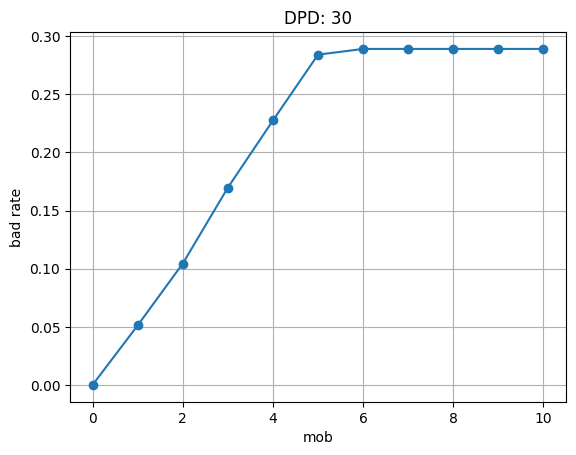

In [30]:
# Set DPD (Days Past Due) threshold to define what constitutes a "bad" or defaulted loan
dpd = 30

# Path to the folder containing CSV files
folder_path = silver_loan_daily_directory

# Read all CSV files into a single DataFrame
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)

# filter only completed loans
df = df.filter(col("loan_start_date") < datetime.strptime("2025-01-01", "%Y-%m-%d"))

# create dpd flag if more than dpd
df = df.withColumn("dpd_flag", F.when(col("dpd") >= dpd, 1).otherwise(0))

# actual bads 
actual_bads_df = df.filter(col("installment_num") == 10)

# visualise bad rate
pdf = df.toPandas()

# Group by col_A and count occurrences in col_B
grouped = pdf.groupby('mob')['dpd_flag'].mean()

# Sort the index (x-axis) of the grouped DataFrame
grouped = grouped.sort_index()

# Plotting
grouped.plot(kind='line', marker='o')

plt.title('DPD: '+ str(dpd))
plt.xlabel('mob')
plt.ylabel('bad rate')
plt.grid(True)
plt.show()


In [31]:
df.toPandas()

,loan_id,Customer_ID,loan_start_date,tenure,installment_num,loan_amt,due_amt,paid_amt,overdue_amt,balance,snapshot_date,mob,installments_missed,first_missed_date,dpd,dpd_flag
0,CUS_0x100b_2024_03_01,CUS_0x100b,2024-03-01,10,10,10000.0,1000.0,1000.0,0.0,0.0,2025-01-01,10,0,None,0,0
1,CUS_0x102e_2024_04_01,CUS_0x102e,2024-04-01,10,9,10000.0,1000.0,0.0,7000.0,8000.0,2025-01-01,9,7,2024-06-01,214,1
2,CUS_0x1038_2024_10_01,CUS_0x1038,2024-10-01,10,3,10000.0,1000.0,1000.0,0.0,7000.0,2025-01-01,3,0,None,0,0
3,CUS_0x103e_2024_12_01,CUS_0x103e,2024-12-01,10,1,10000.0,1000.0,1000.0,0.0,9000.0,2025-01-01,1,0,None,0,0
4,CUS_0x104f_2024_10_01,CUS_0x104f,2024-10-01,10,3,10000.0,1000.0,1000.0,0.0,7000.0,2025-01-01,3,0,None,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131709,CUS_0xe98_2023_01_01,CUS_0xe98,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0,0
131710,CUS_0xea6_2023_01_01,CUS_0xea6,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0,0
131711,CUS_0xed3_2023_01_01,CUS_0xed3,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0,0
131712,CUS_0xed8_2023_01_01,CUS_0xed8,2023-01-01,10,0,10000.0,0.0,0.0,0.0,10000.0,2023-01-01,0,0,None,0,0


## Build Gold Tables

### Label Store

In [32]:
# create gold datalake
gold_label_store_directory = "datamart/gold/label_store/"

if not os.path.exists(gold_label_store_directory):
    os.makedirs(gold_label_store_directory)

In [33]:
# run gold backfill
for date_str in dates_str_lst:
    utils.data_processing_gold_table.process_gold_table_labels(date_str, silver_loan_daily_directory, gold_label_store_directory, spark, dpd = 30, mob = 6)

loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_01_01.parquet row count: 530
Saved to: datamart/gold/label_store/gold_label_store_2023_01_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_02_01.parquet row count: 1031
Saved to: datamart/gold/label_store/gold_label_store_2023_02_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_03_01.parquet row count: 1537
Saved to: datamart/gold/label_store/gold_label_store_2023_03_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_04_01.parquet row count: 2047
Saved to: datamart/gold/label_store/gold_label_store_2023_04_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_05_01.parquet row count: 2568
Saved to: datamart/gold/label_store/gold_label_store_2023_05_01.parquet
loaded from: datamart/silver/lms_loan_daily/silver_lms_loan_daily_2023_06_01.parquet row count: 3085
Saved to: datamart/gold/label_store

In [34]:
inspect_output(gold_label_store_directory).dtypes

loan_id          object
Customer_ID      object
label             int32
label_def        object
snapshot_date    object
dtype: object

### Feature Store

I have decided not to use feature_clickstream.csv, even though it was ingested and cast in the silver layer, due to the lack of documentation on what fe_1 to fe_20 represent, the absence of a clear mapping to predictive behavioral patterns, and the risk of introducing noise or overfitting from ambiguous features.

In [35]:
# create gold datalake
gold_feature_store_directory = "datamart/gold/feature_store/"

if not os.path.exists(gold_feature_store_directory):
    os.makedirs(gold_feature_store_directory)

In [36]:
# run gold backfill
utils.data_processing_gold_table.process_gold_table_features(silver_attributes_directory, silver_financials_directory, gold_feature_store_directory, spark)

Saved to: datamart/gold/feature_store/gold_feature_store.parquet


DataFrame[Customer_ID: string, Age: bigint, Monthly_Inhand_Salary: double, Num_of_Loan: bigint, Delay_from_due_date: bigint, Outstanding_Debt: double, Credit_Utilization_Ratio: double, Credit_History_Age: bigint, Total_EMI_per_month: double, Amount_invested_monthly: double, Occupation_Accountant: bigint, Occupation_Architect: bigint, Occupation_Developer: bigint, Occupation_Doctor: bigint, Occupation_Engineer: bigint, Occupation_Entrepreneur: bigint, Occupation_Journalist: bigint, Occupation_Lawyer: bigint, Occupation_Manager: bigint, Occupation_Mechanic: bigint, Occupation_Media_Manager: bigint, Occupation_Musician: bigint, Occupation_Scientist: bigint, Occupation_Teacher: bigint, Occupation_Writer: bigint, Credit_Mix_Bad: bigint, Credit_Mix_Good: bigint, Credit_Mix_Standard: bigint, Payment_of_Min_Amount_No: bigint, Payment_of_Min_Amount_Yes: bigint, Payment_Behaviour_High_spent_Large_value_payments: bigint, Payment_Behaviour_High_spent_Medium_value_payments: bigint, Payment_Behaviou

In [37]:
# inspect output
inspect_output(gold_feature_store_directory)

,Customer_ID,Age,Monthly_Inhand_Salary,Num_of_Loan,Delay_from_due_date,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,...,Credit_Mix_Good,Credit_Mix_Standard,Payment_of_Min_Amount_No,Payment_of_Min_Amount_Yes,Payment_Behaviour_High_spent_Large_value_payments,Payment_Behaviour_High_spent_Medium_value_payments,Payment_Behaviour_High_spent_Small_value_payments,Payment_Behaviour_Low_spent_Large_value_payments,Payment_Behaviour_Low_spent_Medium_value_payments,Payment_Behaviour_Low_spent_Small_value_payments
0,CUS_0xc47c,33,2602.347412,1,13,306.529999,36.829353,195,18.995377,222.040329,...,1,0,1,0,0,0,0,0,0,1
1,CUS_0xc48a,43,8532.037109,3,27,1287.760010,27.957430,300,163.588852,950.995422,...,0,1,1,0,0,0,0,0,0,1
2,CUS_0xc48b,25,1077.584106,7,36,2685.689941,36.649860,150,49.320873,114.866104,...,0,0,0,1,0,0,0,0,0,1
3,CUS_0xc48c,55,2678.042480,2,22,583.960022,28.931873,395,43.614197,203.553131,...,0,0,0,1,0,0,0,1,0,0
4,CUS_0xc48d,38,2473.916748,4,16,237.520004,38.952030,354,86.821945,26.766159,...,0,1,0,1,0,1,0,0,0,0


### Inspect Label Store

In [38]:
folder_path = gold_label_store_directory
files_list = [folder_path+os.path.basename(f) for f in glob.glob(os.path.join(folder_path, '*'))]
df = spark.read.option("header", "true").parquet(*files_list)
print("row_count:",df.count())

df.show()

row_count: 12500
+--------------------+-----------+-----+----------+-------------+
|             loan_id|Customer_ID|label| label_def|snapshot_date|
+--------------------+-----------+-----+----------+-------------+
|CUS_0x10ac_2024_0...| CUS_0x10ac|    0|30dpd_6mob|   2025-02-01|
|CUS_0x10c5_2024_0...| CUS_0x10c5|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1145_2024_0...| CUS_0x1145|    1|30dpd_6mob|   2025-02-01|
|CUS_0x11ac_2024_0...| CUS_0x11ac|    0|30dpd_6mob|   2025-02-01|
|CUS_0x122c_2024_0...| CUS_0x122c|    0|30dpd_6mob|   2025-02-01|
|CUS_0x1274_2024_0...| CUS_0x1274|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1288_2024_0...| CUS_0x1288|    1|30dpd_6mob|   2025-02-01|
|CUS_0x12cc_2024_0...| CUS_0x12cc|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1338_2024_0...| CUS_0x1338|    0|30dpd_6mob|   2025-02-01|
|CUS_0x1370_2024_0...| CUS_0x1370|    1|30dpd_6mob|   2025-02-01|
|CUS_0x1378_2024_0...| CUS_0x1378|    1|30dpd_6mob|   2025-02-01|
|CUS_0x139b_2024_0...| CUS_0x139b|    0|30dpd_6mob|   2025-

In [39]:
df.printSchema()

root
 |-- loan_id: string (nullable = true)
 |-- Customer_ID: string (nullable = true)
 |-- label: integer (nullable = true)
 |-- label_def: string (nullable = true)
 |-- snapshot_date: date (nullable = true)

